# Navigation


# Install Dependencies

Install Banana
```
cd p1_navigation
wget https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Linux.zip
unzip Banana_Linux.zip
```

Install mujoco200
- https://www.roboti.us/index.html
- https://medium.com/@chinmayburgul/setting-up-mujoco200-on-linux-16-04-18-04-38e5a3524c85

```
cd p1_navigation
lynx https://www.roboti.us/index.html
wget https://www.roboti.us/download/mujoco200_linux.zip
unzip ~/Downloads/mujoco200_linux.zip
mkdir ~/.mujoco
mv ~/Downloads/mujoco200_linux.zip ~/.mujoco/
cd ~/.mujoco/
unzip mujoco200_linux.zip
cd mujoco200_linux/
mv ~/Downloads/LICENSE.txt ~/.mujoco/
mv ~/Downloads/mjkey.txt   ~/.mujoco/
```

Install python dependencies
```
cd p1_navigation
conda create --name drlnd python=3.6
conda activate drlnd
pip install -r p1_navigation/requirements.txt
python -m ipykernel install --user --name drlnd --display-name "drlnd"
```

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [3]:
from matplotlib import pyplot as plt
from unityagents import UnityEnvironment
import numpy as np

 Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [4]:
# from dqn_agent import Agent
# from train import train_dqn
from src.dqn_agent import DQNAgent
from src.model import QNetwork, DuelingQNetwork
from src.train import train_dqn

env = UnityEnvironment(file_name="./Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [7]:
aenv_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]             # get the current state
score = 0                                           # initialize the score
while True:
    action     = np.random.randint(action_size)     # select an action
    env_info   = env.step(action)[brain_name]       # send the action to the environment
    next_state = env_info.vector_observations[0]    # get the next state
    reward     = env_info.rewards[0]                # get the reward
    done       = env_info.local_done[0]             # see if episode has finished
    score     += reward                             # update the score
    state      = next_state                         # roll over the state to next time step
    if done:                                        # exit loop if episode finished
        break
    
print("Score: {}".format(score))


Score: 1.0


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine!


### Basic DQN
**NOTE: See ./src/ directory for source code**

train_dqn( {'obs_attr': 'vector_observations', 'n_episodes': 5000, 'max_t': 2000, 'eps_start': 1.0, 'eps_end': 0.01, 'eps_decay': 0.995, 'score_window_size': 100, 'win_score': 13, 'exit_after_first_reward': False, 'use_future_reward': False} )
Episode  100	Average Score: 0.545
Episode  200	Average Score: 4.04
Episode  300	Average Score: 7.03
Episode  400	Average Score: 10.08
Episode  500	Average Score: 12.36
Episode  536	Average Score: 13.00
Environment solved in 436 episodes!	Average Score: 13.00

DQNAgent.save(): /home/jamie/code/udacity-deep-reinforcement-learning/p1_navigation/models/dqn.pth = 54.1kb


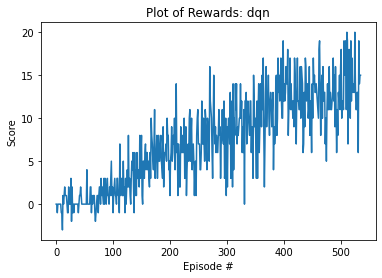

CPU times: user 4min 59s, sys: 22.9 s, total: 5min 22s
Wall time: 8min 5s


In [8]:
%%time
# env   = UnityEnvironment(file_name="./Banana_Linux/Banana.x86_64")
state_size, action_size = DQNAgent.get_env_state_action_size(env)  #  state_size == 37, action_size == 4

scores    = []
modelname = f'dqn'
agent     = DQNAgent(state_size, action_size, model_class=QNetwork)
scores = train_dqn(
    env,
    agent,
    max_t=2000,
    n_episodes=5000,
    filename=f'models/{modelname}.pth'
)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.title(f'Plot of Rewards: {modelname}')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig(f'models/{modelname}.png', bbox_inches='tight')
plt.show()

Average score converges to about 5, with a maximum score of 11

### Dueling DQN

train_dqn( {'obs_attr': 'vector_observations', 'n_episodes': 5000, 'max_t': 2000, 'eps_start': 1.0, 'eps_end': 0.01, 'eps_decay': 0.995, 'score_window_size': 100, 'win_score': 13, 'exit_after_first_reward': False, 'use_future_reward': False} )
Episode  100	Average Score: 0.420
Episode  200	Average Score: 2.59
Episode  300	Average Score: 6.42
Episode  400	Average Score: 10.74
Episode  474	Average Score: 13.02
Environment solved in 374 episodes!	Average Score: 13.02

DQNAgent.save(): /home/jamie/code/udacity-deep-reinforcement-learning/p1_navigation/models/dueling_dqn.pth = 71.8kb


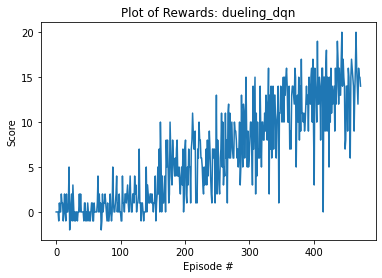

CPU times: user 5min 42s, sys: 19.7 s, total: 6min 1s
Wall time: 8min 27s


In [9]:
%%time
# env   = UnityEnvironment(file_name="./Banana_Linux/Banana.x86_64")
state_size, action_size = DQNAgent.get_env_state_action_size(env)  #  state_size == 37, action_size == 4

scores    = []
modelname = f'dueling_dqn'
agent     = DQNAgent(state_size, action_size, model_class=DuelingQNetwork)
scores = train_dqn(
    env,
    agent,
    max_t=2000,
    n_episodes=5000,
    filename=f'models/{modelname}.pth'
)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.title(f'Plot of Rewards: {modelname}')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig(f'models/{modelname}.png', bbox_inches='tight')
plt.show()